# Compute mistakenness

### Init fiftyone

In [6]:
import os
from pathlib import Path

config_path = Path.home() / ".fiftyone" / "config.global_mongodb.json"
os.environ["FIFTYONE_CONFIG_PATH"] = str(config_path)

In [7]:
import fiftyone as fo

fo.list_datasets()

['16BIT8BIT_DATASET',
 '2024.04.10.13.33.17',
 'ALIGNED_DS_NAT',
 'HENSOLDT',
 'OUTSOURCE_SEG_ANNOTATIONS',
 'PANOPTIC_DATASET_OPT110k',
 'SAILING_DATASET',
 'SAILING_DATASET_07_03_2025',
 'SAILING_DATASET_QA',
 'SAILING_PANOPTIC_DATASET_QA',
 'SAILING_TMP_83',
 'SAM_TRACK_DATASET',
 'SAM_TRACK_IMAGES',
 'SAM_TRACK_KEY_FRAMES_DATASET',
 'SEGMENTATION_DATASET',
 'SEGMENTATION_DATASET_CURATED_MS',
 'SEGMENTATION_DATASET_PRE_ANNOTATED',
 'SEGMENT_BB_DATASET',
 'SENTRY_16BIT8BIT_DATASET',
 'SENTRY_IMAGES_SUBSAMPLE',
 'SENTRY_PANOPTIC_DATASET_QA',
 'SENTRY_SPLIT_VIDEOS_DATASET',
 'SENTRY_VIDEOS_DATASET_ALL',
 'SENTRY_VIDEOS_DATASET_QA',
 'TRAIN_PANOPTIC_DATASET',
 'TRAIN_PANOPTIC_OPTIMIZED_NAT',
 'TRAIN_PANOPTIC_OPTIMIZED_SR10',
 'TRAIN_RL_SPLIT_THERMAL_2023_11',
 'TRAIN_RL_SPLIT_THERMAL_2024_03',
 'TRAIN_THERMAL_DATASET_2023_06',
 'my-dataset']

### Launch app

In [8]:
dataset_name = "TRAIN_RL_SPLIT_THERMAL_2024_03"
dataset = fo.load_dataset(dataset_name)

session = fo.launch_app(dataset=dataset, port=2203, address="127.0.0.1", auto=False)
session.show()

Session launched. Run `session.show()` to open the App in a cell output.


### Cast labels to classes used by prediction model (yolov5)

The class_map.yaml file can be found here: https://github.com/SEA-AI/yolov5/blob/sea.ai/data/class_map.yaml

In [20]:
import yaml


def load_class_map(class_map_file_path: str):
    with open(class_map_file_path, "r") as file:
        return yaml.safe_load(file)


def cast_label(label: str, cast_dict: dict):
    if label in cast_dict:
        return cast_dict[label]
    return label


class_map = load_class_map("class_map.yaml")

print("Test: HUMAN_IN_WATER -->", cast_label("HUMAN_IN_WATER", class_map))

Test: HUMAN_IN_WATER --> HUMAN


In [7]:
def cast_labels(
    dataset: fo.core.dataset.Dataset,
    class_map_file_path: str,
    sample_field="ground_truth_det_yolo",
):
    class_map = load_class_map(class_map_file_path)

    for sample in dataset.iter_samples(progress=True):
        detections_list = []

        if sample.ground_truth_det is not None:
            for det in sample.ground_truth_det.detections:
                label = cast_label(det.label, class_map)

                # if label is None than it is igored in training and should also be skipped here
                if label == "None":
                    continue

                detection = fo.Detection(
                    label=label, bounding_box=det.bounding_box, index=det.index
                )
                detections_list.append(detection)

        det_list = fo.core.labels.Detections(detections=detections_list)
        sample[sample_field] = det_list

        sample.save()

    dataset.save()


# Cast labels
print("Casting labels...")
cast_labels(
    dataset=dataset,
    sample_field="ground_truth_det_yolo",
    class_map_file_path="class_map.yaml",
)

   0% ||--------------|    0/1000 [3.5ms elapsed, ? remaining, ? samples/s] 

 100% |███████████████| 1000/1000 [2.5s elapsed, 0s remaining, 414.3 samples/s]      


### Object Detection Inference with YOLOv5

In [9]:
import yolov5
import cv2


def add_yolov5_predictions(dataset: fo.core.dataset.Dataset, sample_field: str):
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = yolov5.load("SEA-AI/yolov5n-IR").to(device)

    # Configure model parameters
    model.conf = 0.1  # NMS confidence threshold
    model.iou = 0.1  # NMS IoU threshold
    model.agnostic = True  # NMS class-agnostic

    for sample in dataset.iter_samples(progress=True):
        if "ADDED_YOLO_PREDICTION" in sample.tags:
            continue

        # Load image
        frame = cv2.imread(sample.filepath)
        h, w, _ = frame.shape

        # Make prediciton
        results = model(frame, size=640)

        detections = []

        for *box, conf, cls in results.xyxy[0]:
            # FiftyOne expects [top-left-x, top-left-y, width, height] normalized to [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]
            detections.append(
                fo.Detection(
                    label=model.names[int(cls)],
                    bounding_box=rel_box,
                    confidence=conf,
                )
            )

        det_list = fo.core.labels.Detections(detections=detections)
        sample[sample_field] = det_list
        sample.tags.append("ADDED_YOLO_PREDICTION")

        sample.save()

    dataset.save()


# Add yolo predictions to the dataset
print("Adding yolo predictions...")
add_yolov5_predictions(dataset=dataset, sample_field="yolo_prediction")

 100% |███████████████| 1000/1000 [5.0m elapsed, 0s remaining, 3.5 samples/s]      


### Add region classification 

In [ ]:
import torch
from ultralytics import YOLO


def add_region_predicitions(
    dataset: fo.core.dataset.Dataset,
    weights_file_path: str,
    sample_field_ground_truth="region_ground_truth",
    sample_field_prediction="region_prediction",
):
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = YOLO(weights_file_path).to(device)

    classes = ["LAKE", "HARBOUR", "OPEN_SEA", "SHORELINE"]

    for sample in dataset.iter_samples(progress=True):
        # Make region prediction
        region_prediction = model.predict(sample.filepath, verbose=False)

        # Extract label and confidence
        label = classes[region_prediction[0].cpu().probs.numpy().top1]
        confidence = region_prediction[0].cpu().probs.numpy().top1conf

        # Add fields to sample
        sample[sample_field_ground_truth] = fo.Classification(label=sample.region)
        sample[sample_field_prediction] = fo.Classification(
            label=label, confidence=confidence
        )

        sample.save()

    dataset.save()


# Add region prediction to the dataset
print("Adding region predictions...")
add_region_predicitions(dataset=dataset, weights_file_path="./weights/best.pt")

### Compute mistakenness

* Compute mistakenness metric for object detections
* Add mistakenness_loc on sample level
* Compute mistakenness metric for region classification

In [ ]:
import fiftyone.brain as fob


def add_mistakenness_loc_metric(
    dataset: fo.core.dataset.Dataset,
    label_field="ground_truth_det",
    sample_field="mistakenness_loc",
):
    # Specify field as float to prevent cast issues
    dataset.add_sample_field(sample_field, fo.FloatField)

    for sample in dataset.iter_samples(progress=True):
        detections = sample[label_field]

        # Extract the mistakenness_loc values from detections
        mistakenness_loc_values = [
            det.mistakenness_loc
            for det in detections.detections
            if hasattr(det, "mistakenness_loc")
        ]

        # Assign the maximum mistakenness_loc to the sample field, or -1.0 if there are no detections
        sample["mistakenness_loc"] = max(mistakenness_loc_values, default=-1.0)

        sample.save()

    dataset.save()


def compute_mistakenness(
    dataset: fo.core.dataset.Dataset,
    mistakenness_field_detections="mistakenness",
    mistakenness_field_region_classification="mistakenness_region",
    pred_field="yolo_prediction",
    label_field="ground_truth_det_yolo",
):
    """
    IMPORTANT!!!
    To customize the default settings for mistakenness computation, update the values in the mistakenness.py file located in the fiftyone.brain module:
    (fiftyone/brain/internal/core/mistakenness.py lines 34-35)

    _MISSED_CONFIDENCE_THRESHOLD = 0.5  # Threshold for detection confidence to be considered as missed
    _DETECTION_IOU = 0.01  # Threshold for Intersection over Union (IoU) to consider a detection as a match
    """

    # Add this fields to prevent cast issued when calculating mistakenness (otherwise the mistakeness score will possibly be casted to integers)
    dataset.add_sample_field(mistakenness_field_detections, fo.FloatField)
    dataset.add_sample_field(mistakenness_field_region_classification, fo.FloatField)

    # Compute mistakenness for object detections
    fob.compute_mistakenness(
        dataset,
        pred_field=pred_field,
        label_field=label_field,
        mistakenness_field=mistakenness_field_detections,
    )

    # Add mistaknness_loc field on sample level
    add_mistakenness_loc_metric(dataset, label_field="ground_truth_det_yolo")

    # Compute mistakenness for region classification
    fob.compute_mistakenness(
        dataset,
        pred_fiels="region_prediction",
        label_field="region_ground_truth",
        mistakenness_field=mistakenness_field_region_classification,
    )


# Computing mistakenness
print("Computing mistakenness...")
compute_mistakenness(dataset=dataset)

### Sort by mistakenness

In [27]:
mistakenness_view = dataset.sort_by("mistakenness", reverse=True)
session.view = mistakenness_view

### Sort by mistakenness_loc

In [ ]:
mistakenness_view = dataset.sort_by("mistakenness_loc", reverse=True)
session.view = mistakenness_view

### Delete mistakenness metrics

In [ ]:
dataset.delete_sample_field("mistakenness_loc")
dataset.delete_brain_run("mistakenness")
dataset.delete_brain_run("mistakenness_region")
dataset.delete_evaluations()

## Evaluate mistakenness metric

In [34]:
from fiftyone import ViewField as F
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

# Assuming `dataset` and `agg` are defined elsewhere

# Preallocate label_scores
label_scores = defaultdict(lambda: {"mistakenness": [], "mistakenness_loc": [], "possible_missing": [], "possible_spurious": []})

# Aggregate mistakenness, mistakenness_loc, possible_spurious, and possible_missing scores by label
for sample in tqdm(dataset):
    # Extract scores using list comprehensions and update label_scores
    for det in sample.ground_truth_det_yolo.detections:
        label_scores[det.label]["mistakenness"].extend([det.mistakenness for _ in range(int(hasattr(det, "mistakenness")))])  
        label_scores[det.label]["mistakenness_loc"].extend([det.mistakenness_loc for _ in range(int(hasattr(det, "mistakenness_loc")))]) 
        label_scores[det.label]["possible_spurious"].extend([int(det.possible_spurious) for _ in range(int(hasattr(det, "possible_spurious")))])
    
    for det in sample.yolo_prediction.detections:
        label_scores[det.label]["possible_missing"].extend([int(det.possible_missing) for _ in range(int(hasattr(det, "possible_missing")))])


    

100%|██████████| 262289/262289 [25:24<00:00, 172.03it/s] 


#### Set style

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set global style for seaborn
sns.set_style("whitegrid")


# Use a predefined color palette
pallet_name="Set3"
palette = sns.color_palette(pallet_name, len(label_scores.keys()))

### Histograms per class

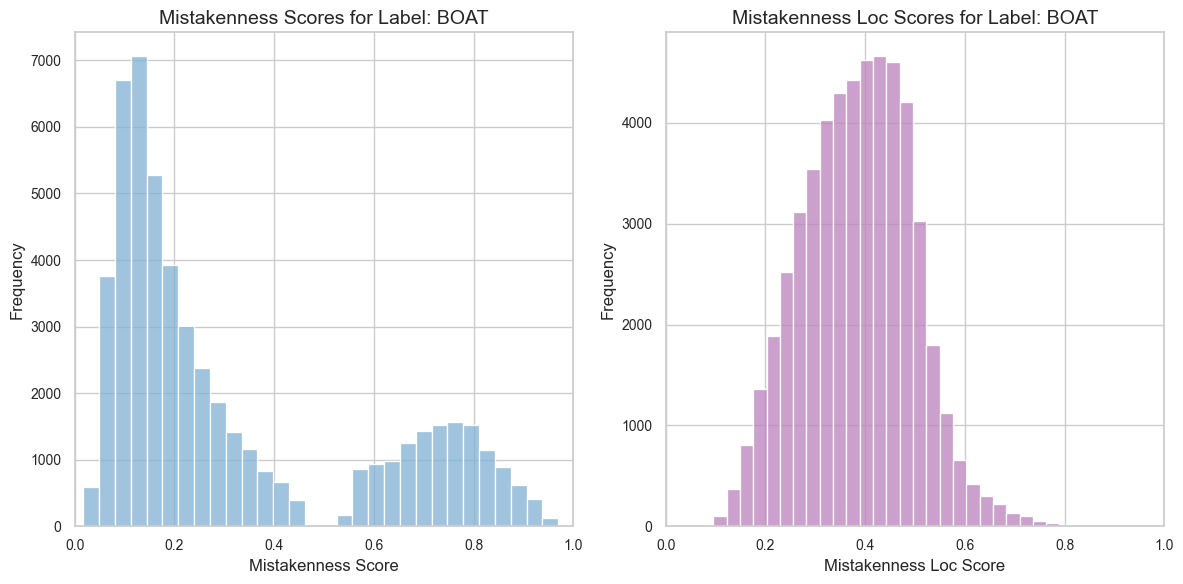

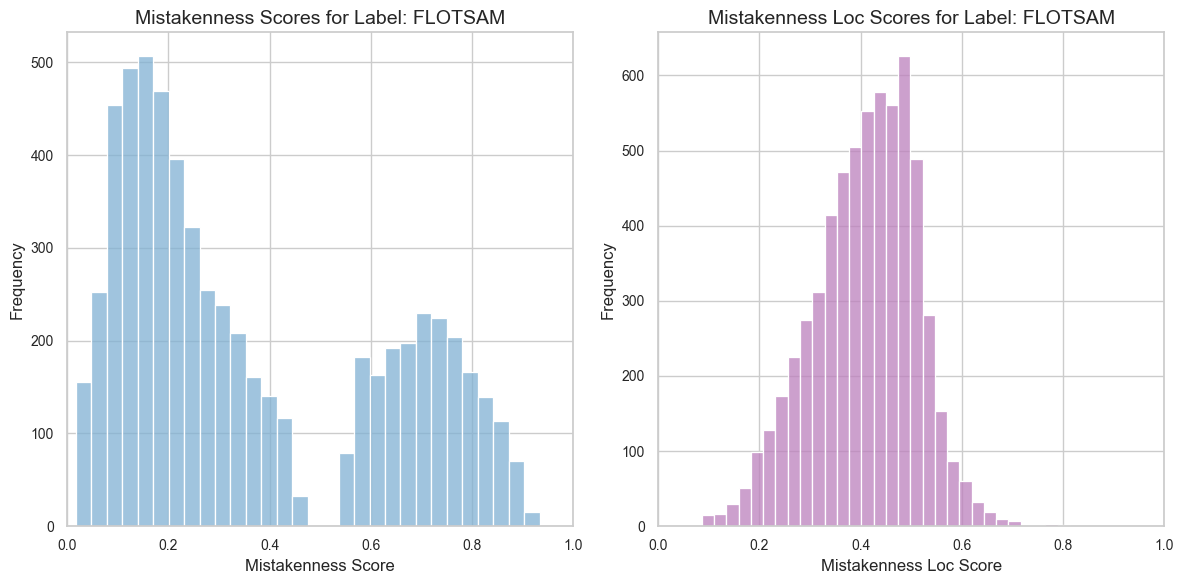

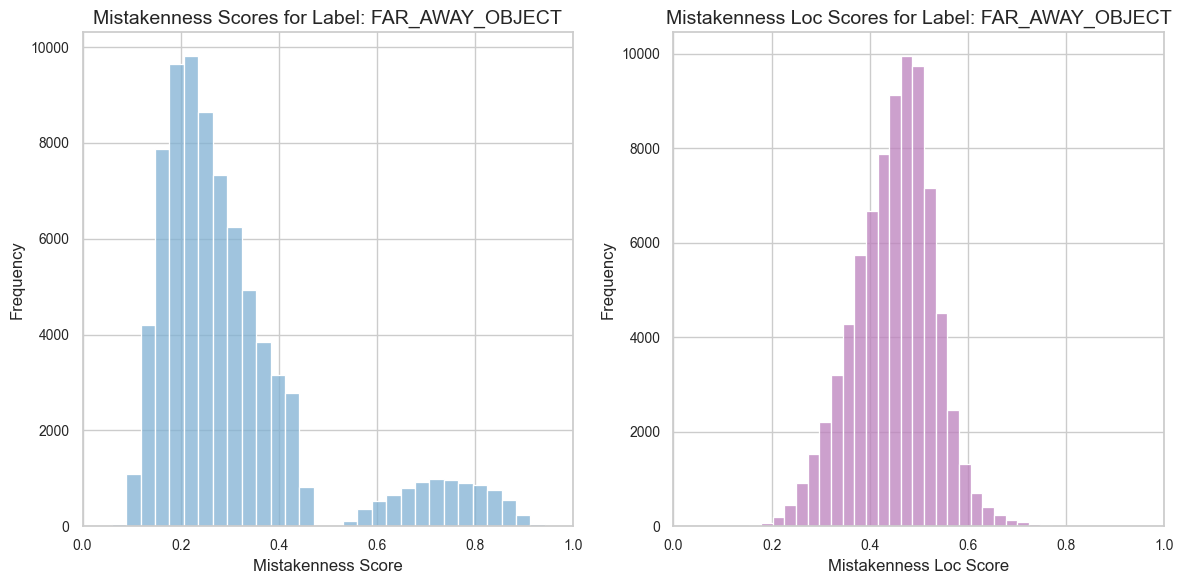

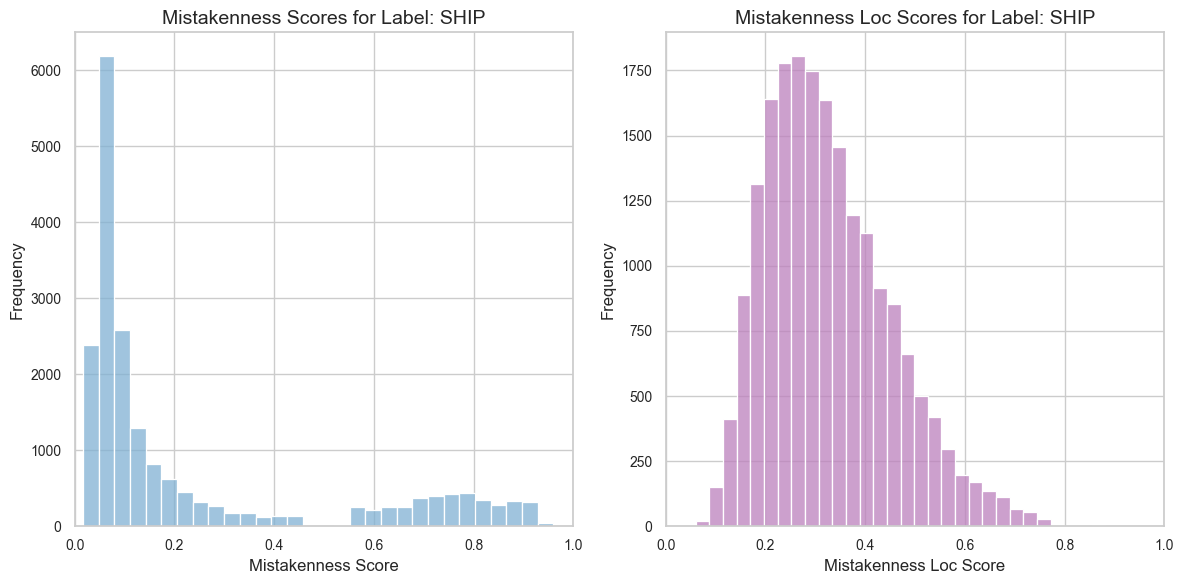

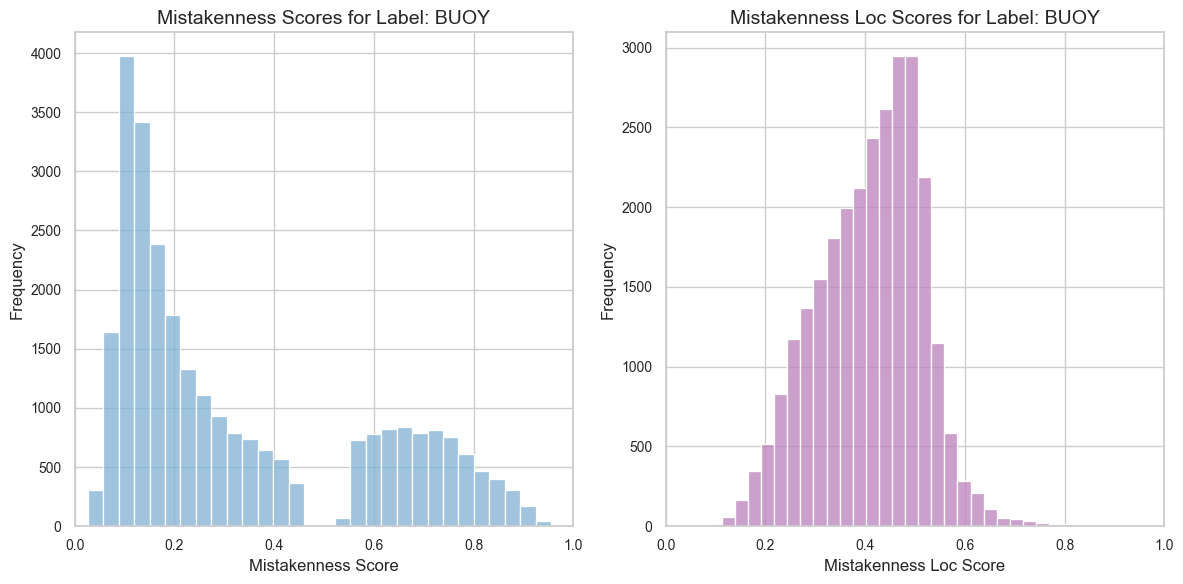

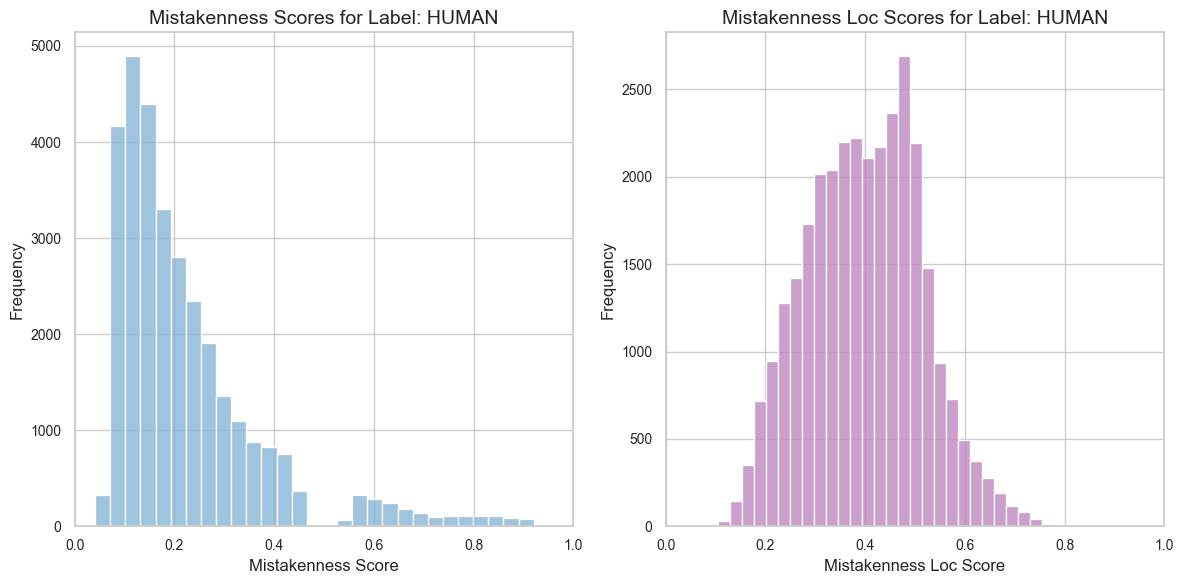

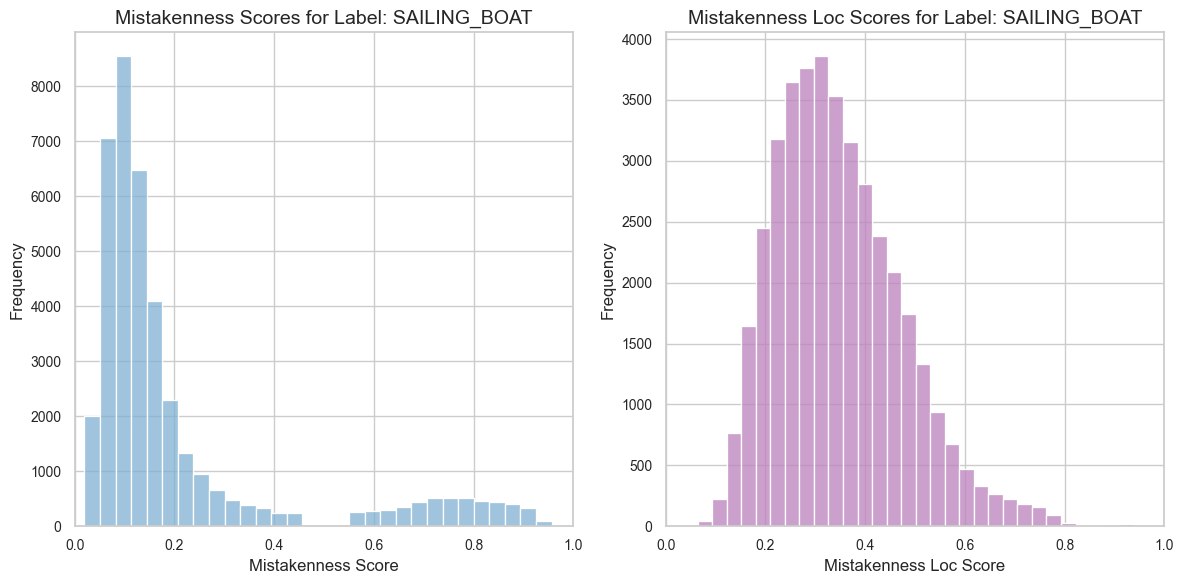

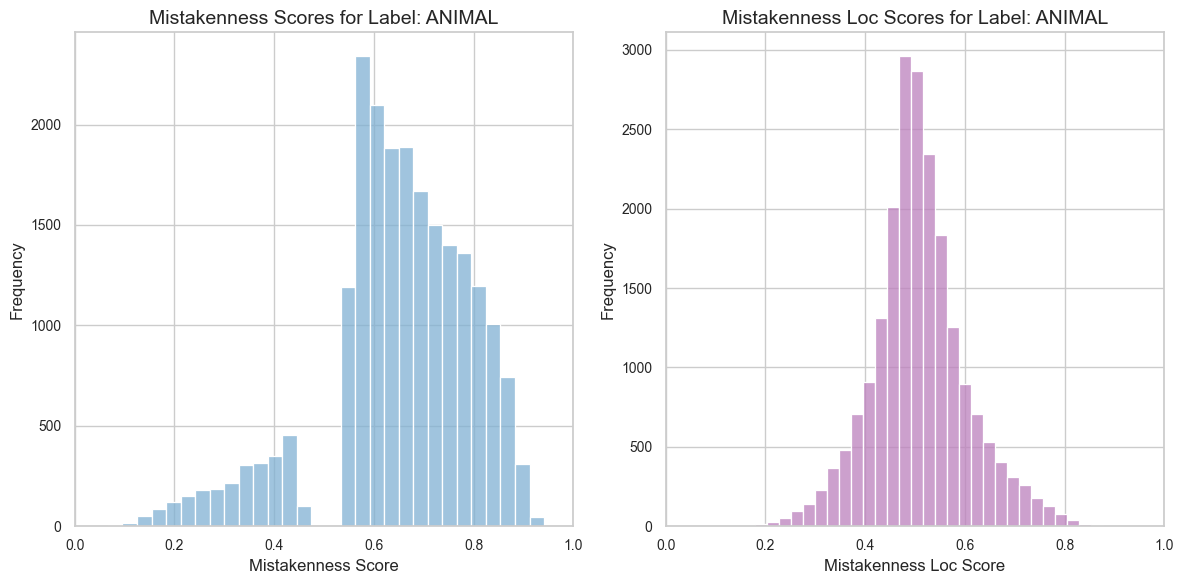

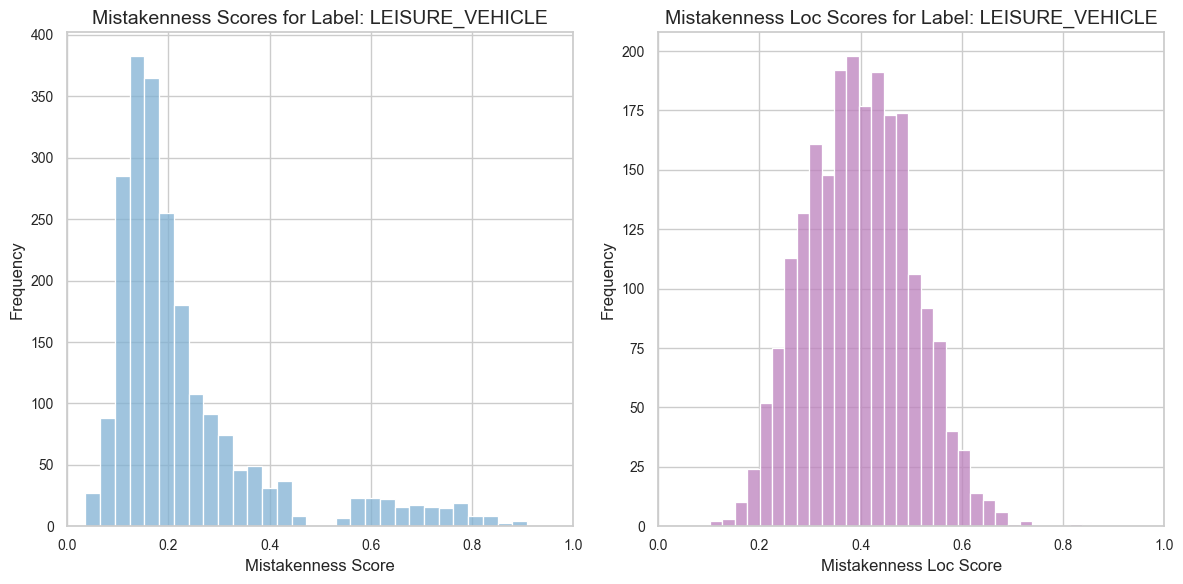

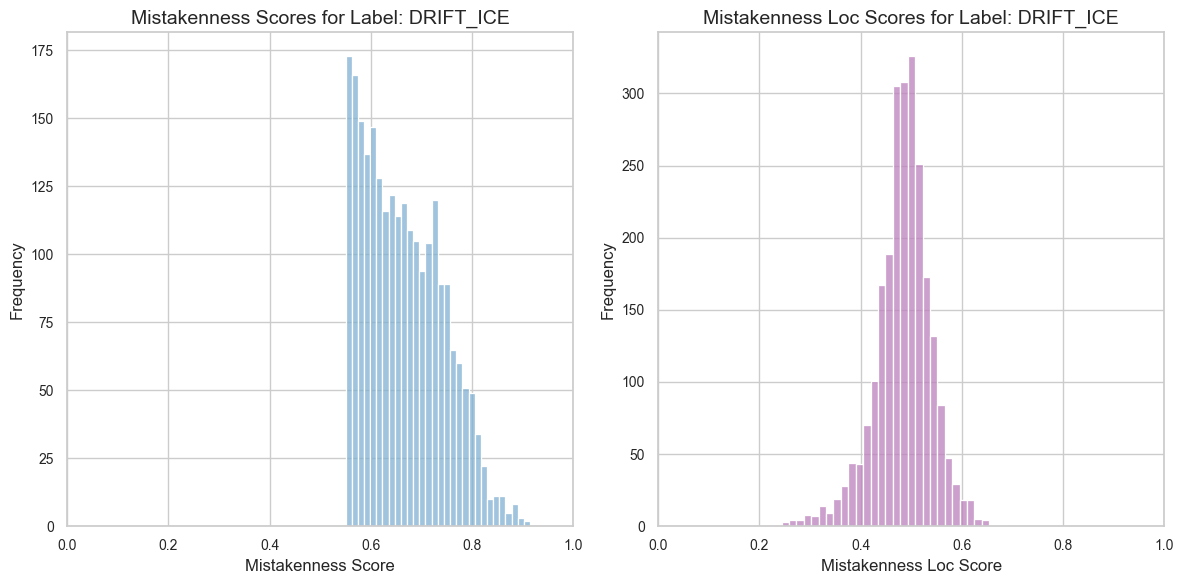

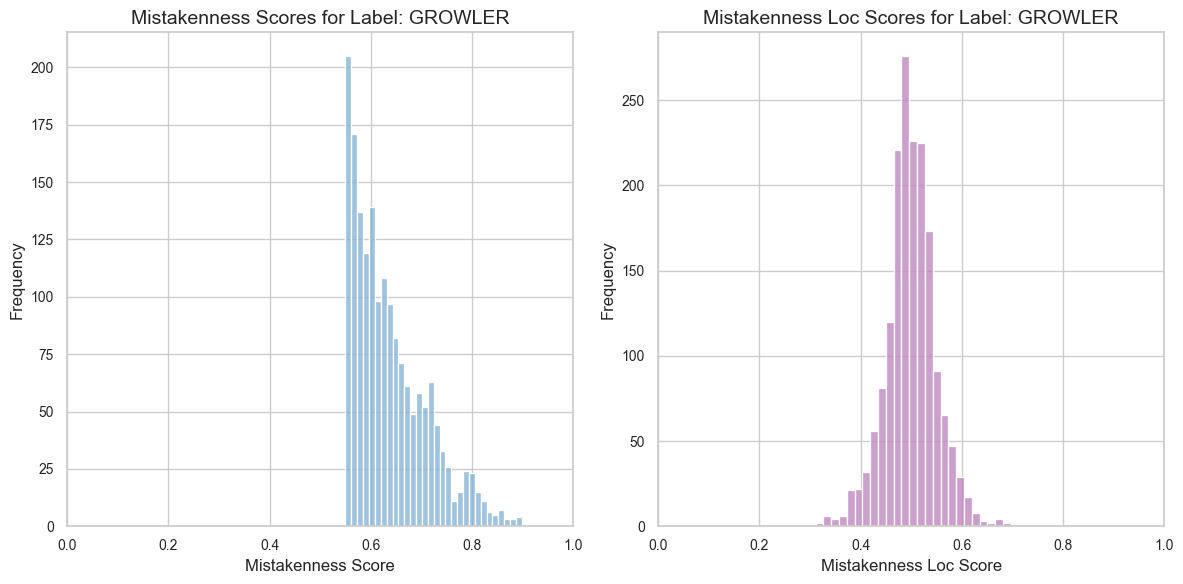

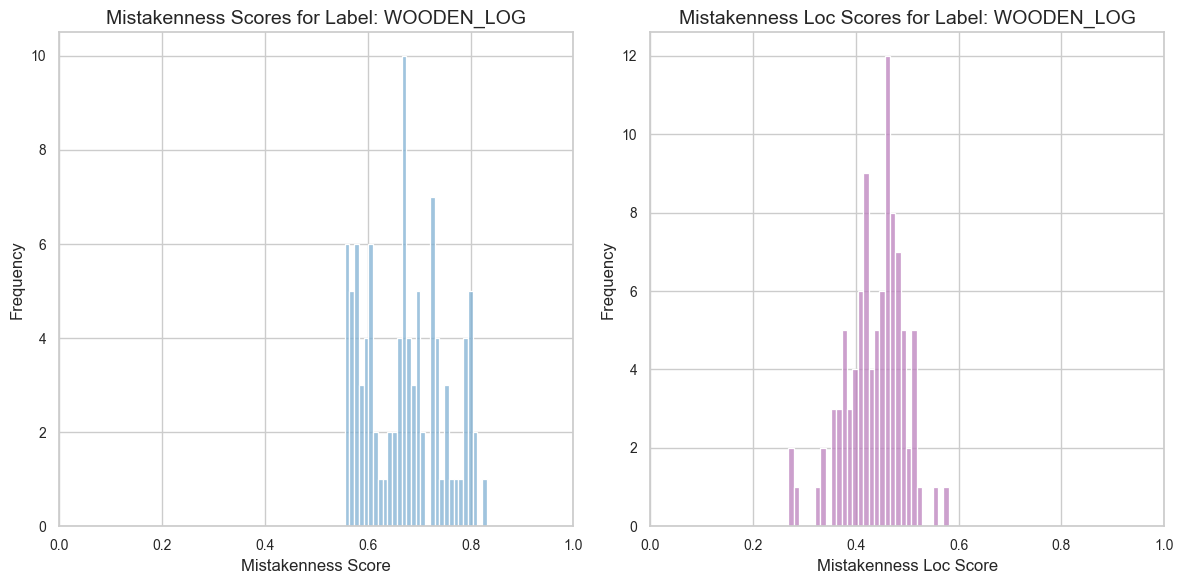

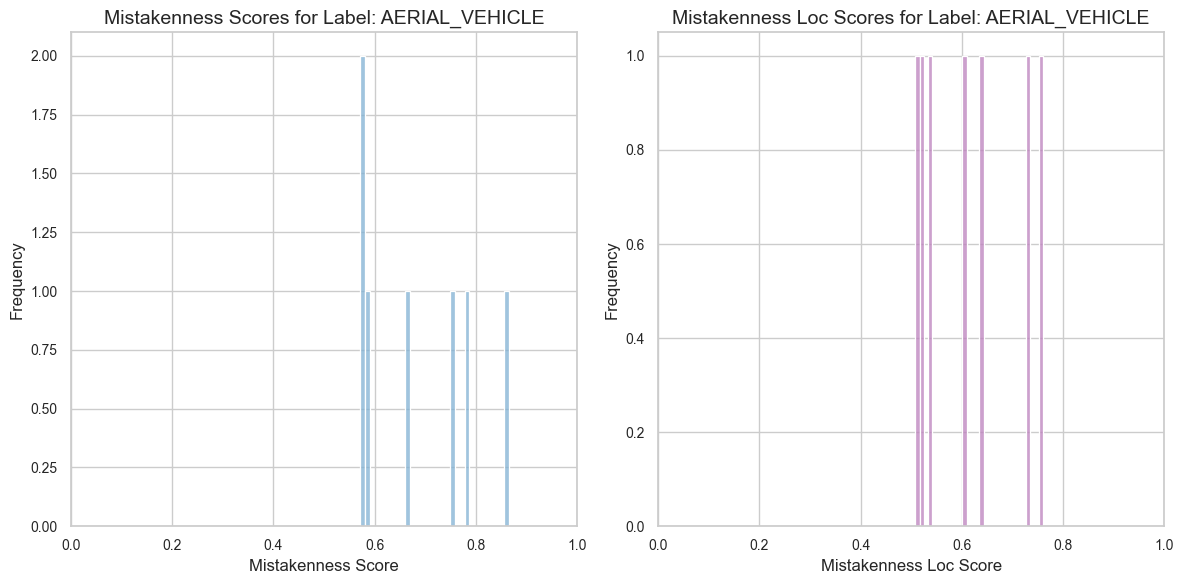

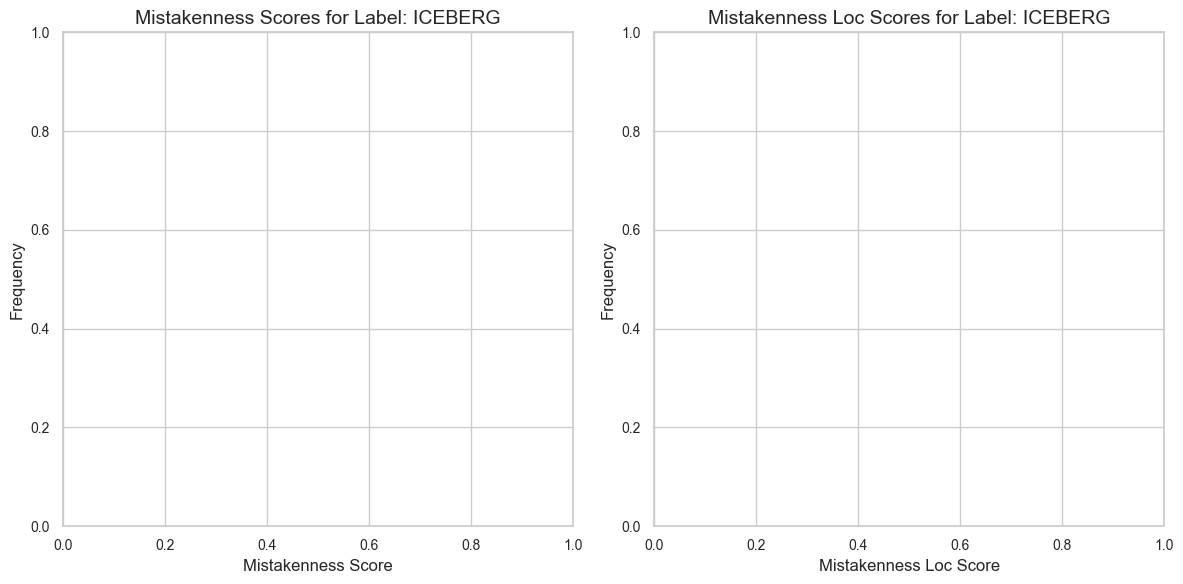

In [94]:
# Plot histograms for each label
for label, scores in label_scores.items():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot mistakenness histogram
    sns.histplot(scores["mistakenness"], bins=30, color=palette[4], ax=axs[0])
    axs[0].set_title("Mistakenness Scores for Label: " + label, fontsize=14)
    axs[0].set_xlabel("Mistakenness Score", fontsize=12)
    axs[0].set_ylabel("Frequency", fontsize=12)
    axs[0].set_xlim(0, 1)  # Set x-axis range to 0-1

    # Plot mistakenness_loc histogram
    sns.histplot(scores["mistakenness_loc"], bins=30, color=palette[9], ax=axs[1])
    axs[1].set_title("Mistakenness Loc Scores for Label: " + label, fontsize=14)
    axs[1].set_xlabel("Mistakenness Loc Score", fontsize=12)
    axs[1].set_ylabel("Frequency", fontsize=12)
    axs[1].set_xlim(0, 1)  # Set x-axis range to 0-1

    # Set tick parameters for all axes
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.tick_params(axis='both', which='minor', labelsize=8)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

    plt.show()


### Statistics (mean, median, std, q1, q3)

In [95]:
import numpy as np

# Dictionary to store summary statistics for each class
summary_statistics = {}

for label, scores in label_scores.items():
    # Calculate summary statistics for mistakenness scores
    mistakenness = np.array(scores["mistakenness"])

    if(mistakenness.size == 0):
        continue
    
    mean_mistakenness = np.mean(mistakenness)
    median_mistakenness = np.median(mistakenness)
    std_mistakenness = np.std(mistakenness)
    q1_mistakenness = np.percentile(mistakenness, 25)
    q3_mistakenness = np.percentile(mistakenness, 75)

    # Store summary statistics in the dictionary
    summary_statistics[label] = {
        "mean": mean_mistakenness,
        "median": median_mistakenness,
        "std": std_mistakenness,
        "q1": q1_mistakenness,
        "q3": q3_mistakenness,
    }

# Print summary statistics for each class
for label, stats in summary_statistics.items():
    print("Class:", label)
    print("Mean:", stats["mean"])
    print("Median:", stats["median"])
    print("Standard Deviation:", stats["std"])
    print("Q1 (25th Percentile):", stats["q1"])
    print("Q3 (75th Percentile):", stats["q3"])
    print()

Class: BOAT
Mean: 0.318876956950632
Median: 0.19798821210861206
Standard Deviation: 0.2618307064861613
Q1 (25th Percentile): 0.12082616984844208
Q3 (75th Percentile): 0.5624294755980372

Class: FLOTSAM
Mean: 0.36581381061351836
Median: 0.2659609466791153
Standard Deviation: 0.2583992296196807
Q1 (25th Percentile): 0.15223154425621033
Q3 (75th Percentile): 0.6286786049604416

Class: FAR_AWAY_OBJECT
Mean: 0.3086855705637156
Median: 0.2589401751756668
Standard Deviation: 0.17137483773380166
Q1 (25th Percentile): 0.19756454229354858
Q3 (75th Percentile): 0.3504059314727783

Class: SHIP
Mean: 0.23527317467988904
Median: 0.09101030230522156
Standard Deviation: 0.27265511644824636
Q1 (25th Percentile): 0.059454500675201416
Q3 (75th Percentile): 0.27097275853157043

Class: BUOY
Mean: 0.330742056918839
Median: 0.21771341562271118
Standard Deviation: 0.2508665501987412
Q1 (25th Percentile): 0.1264188587665558
Q3 (75th Percentile): 0.5800255872309208

Class: HUMAN
Mean: 0.22462198730542124
Median

### Class rank

In [97]:
# Calculate mean mistakenness score for each class
class_mistakenness_mean = {
    label: np.mean(scores["mistakenness"]) for label, scores in label_scores.items()
}

# Sort classes based on mean mistakenness score in descending order
ranked_classes = sorted(
    class_mistakenness_mean.items(), key=lambda x: x[1], reverse=False
)

# Print ranked classes
print("Ranked Classes based on Mean Mistakenness Score:")
for i, (label, mean_mistakenness) in enumerate(ranked_classes, start=1):
    print(f"{i}. {label}: Mean Mistakenness Score = {mean_mistakenness:.2f}")

Ranked Classes based on Mean Mistakenness Score:
1. SAILING_BOAT: Mean Mistakenness Score = 0.21
2. HUMAN: Mean Mistakenness Score = 0.22
3. LEISURE_VEHICLE: Mean Mistakenness Score = 0.23
4. SHIP: Mean Mistakenness Score = 0.24
5. FAR_AWAY_OBJECT: Mean Mistakenness Score = 0.31
6. BOAT: Mean Mistakenness Score = 0.32
7. BUOY: Mean Mistakenness Score = 0.33
8. FLOTSAM: Mean Mistakenness Score = 0.37
9. GROWLER: Mean Mistakenness Score = 0.64
10. ANIMAL: Mean Mistakenness Score = 0.65
11. DRIFT_ICE: Mean Mistakenness Score = 0.66
12. WOODEN_LOG: Mean Mistakenness Score = 0.67
13. AERIAL_VEHICLE: Mean Mistakenness Score = 0.68
14. ICEBERG: Mean Mistakenness Score = nan


### Boxplots and Violinplots

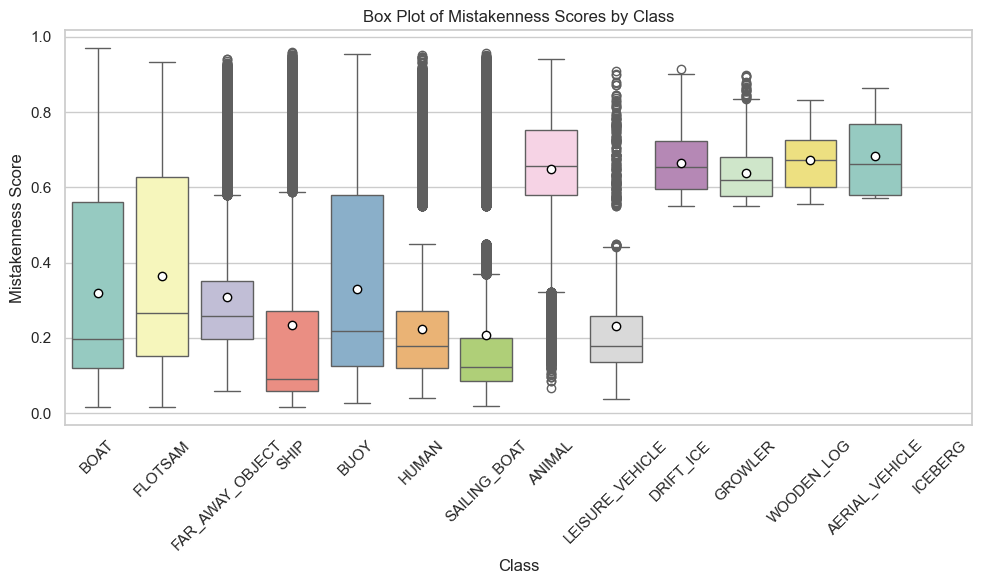

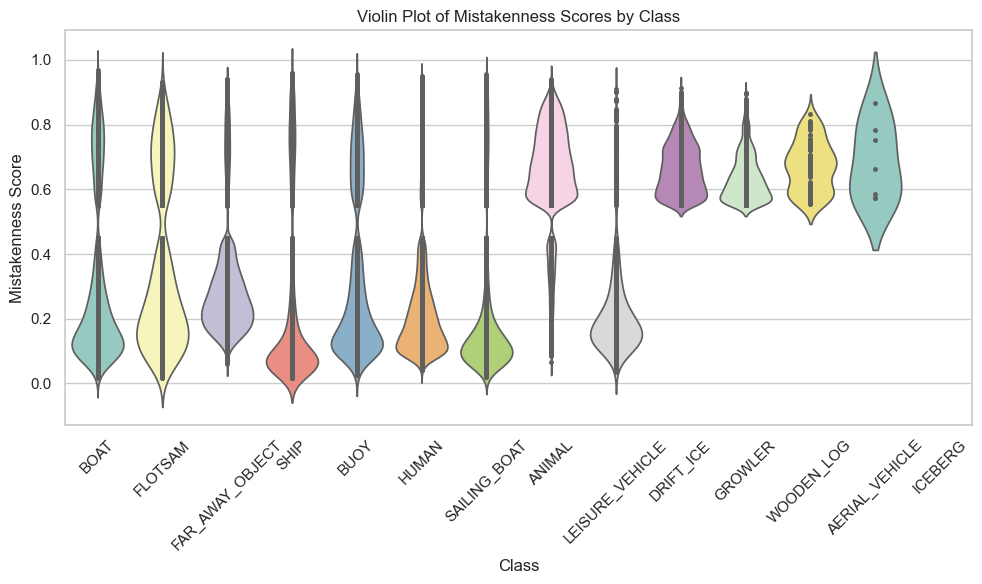

In [98]:
def plot_boxplot(data, labels):
    sns.boxplot(data=data, palette=pallet_name, showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"})
    plt.title("Box Plot of Mistakenness Scores by Class")
    plt.xlabel("Class")
    plt.ylabel("Mistakenness Score")
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_violinplot(data, labels):
    sns.violinplot(data=data, inner="point", palette=pallet_name) 
    plt.title("Violin Plot of Mistakenness Scores by Class")
    plt.xlabel("Class")
    plt.ylabel("Mistakenness Score")
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.tight_layout()
    plt.show()

# Set Seaborn style
sns.set(style="whitegrid")

# List to store mistakenness scores for each class
mistakenness_scores_by_class = [scores["mistakenness"] for scores in label_scores.values()]

# Create and show box plot
plt.figure(figsize=(10, 6))
plot_boxplot(mistakenness_scores_by_class, label_scores.keys())

# Create and show violin plot
plt.figure(figsize=(10, 6))
plot_violinplot(mistakenness_scores_by_class, label_scores.keys())



### Possible missing and spurious per class

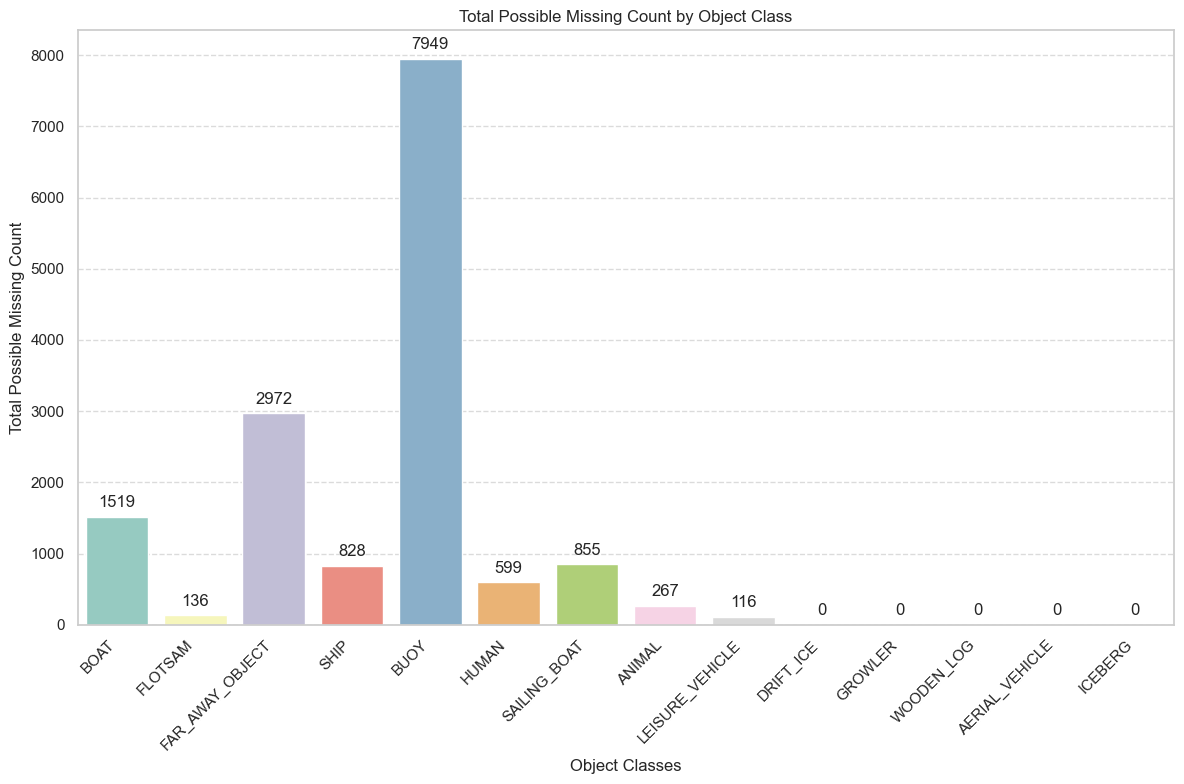

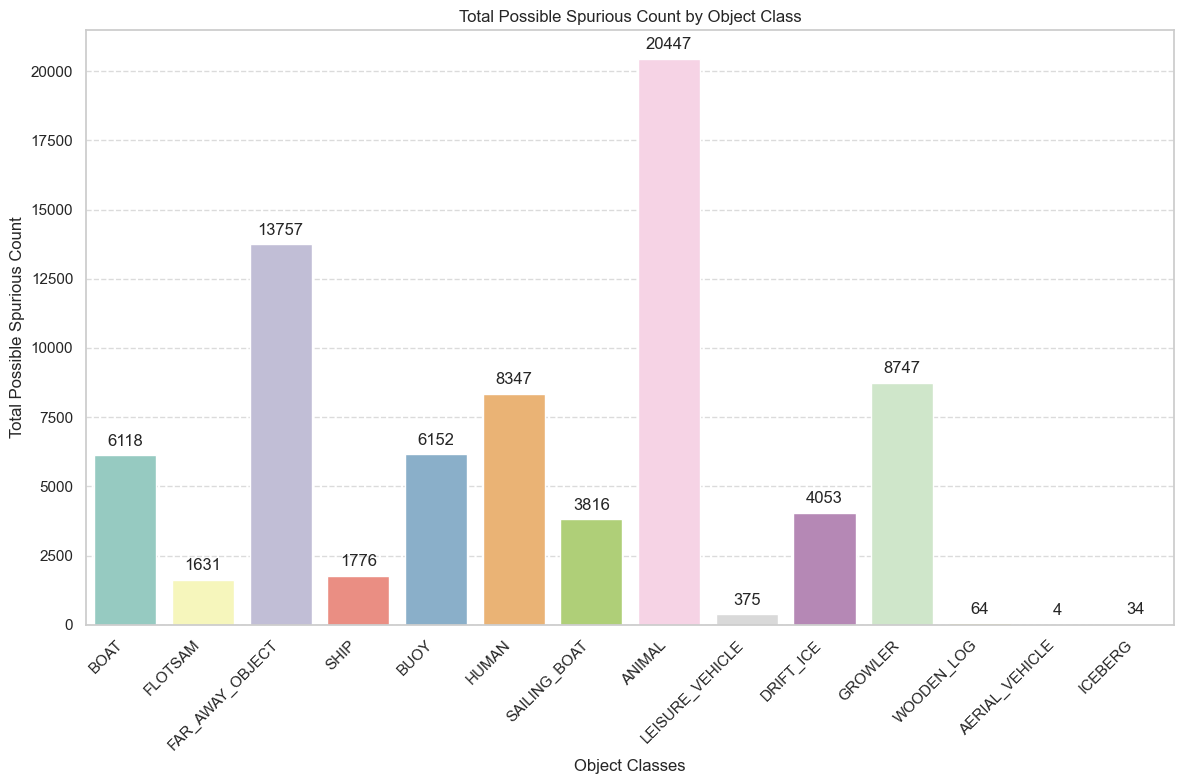

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_barplot(data, ylabel, title):
    ax = sns.barplot(x=list(data.keys()), y=data.values(), hue=list(data.keys()), palette=pallet_name, dodge=False)
    plt.xlabel('Object Classes')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add actual numbers on top of the bars
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 10), 
                     textcoords = 'offset points')
    
    plt.tight_layout()
    plt.show()

# Calculate total possible missing scores for each class
possible_missing_by_class = {label: sum(scores["possible_missing"]) for label, scores in label_scores.items()}

# Plot
plt.figure(figsize=(12, 8))
plot_barplot(possible_missing_by_class, 'Total Possible Missing Count', 'Total Possible Missing Count by Object Class')

# Calculate total possible spurious scores for each class
possible_spurious_by_class = {label: sum(scores["possible_spurious"]) for label, scores in label_scores.items()}

# Plot
plt.figure(figsize=(12, 8))
plot_barplot(possible_spurious_by_class, 'Total Possible Spurious Count', 'Total Possible Spurious Count by Object Class')
